# Inference a real model

How to inference a real model trainned by another framework like tensorflow/pytorch/PDPD?

Assume the model is supported by OpenVINO, here is the process of running inference using 
This is little complex in OpenVINO, offline conversion(model optimizer)

## Download onnx model

```bash
wget https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet18-v1-7.tar.gz
tar -xf resnet18-v1-7.tar.gz
```

## Read the model

In [1]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np
import time
from pandas import DataFrame
from graphviz import Digraph, Source
import ovhelper


# this is top object
core = ov.Core()

model = core.read_model("./resnet18-v1-7/resnet18-v1-7.onnx")

ovhelper.print_model(model)

model(Parameter_102):
    Tensor<1x3x224x224xf32> t1 = Parameter(element_type=f32)    # data
    Tensor<64x3x7x7xf32> t2 = Constant(element_type=f32,shape=[64, 3, 7, 7])    # resnetv15_conv0_weight
    Tensor<1x64x112x112xf32> t3 = Convolution(t1,t2,strides=[2, 2],dilations=[1, 1],pads_begin=[3, 3],pads_end=[3, 3],auto_pad=explicit)    # resnetv15_conv0_fwd
    Tensor<64xf32> t4 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_gamma
    Tensor<64xf32> t5 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_beta
    Tensor<64xf32> t6 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_running_mean
    Tensor<64xf32> t7 = Constant(element_type=f32,shape=[64])    # resnetv15_batchnorm0_running_var
    Tensor<1x64x112x112xf32> t8 = BatchNormInference(t3,t4,t5,t6,t7,epsilon=9.999999747378752e-06)    # resnetv15_batchnorm0_fwd
    Tensor<1x64x112x112xf32> t9 = Relu(t8)    # resnetv15_relu0_fwd
    Tensor<1x64x56x56xf32> t10,Tensor<1x64x56x56xi64> t

Very convenient, now lets compile it into CPU runtime model.

In [2]:
device = 'CPU'
# enable PERF_COUNT
core.set_property(device, {"PERF_COUNT": "YES"})

compiled_model = core.compile_model(model, device)

for k, input in enumerate(compiled_model.inputs):
    print("inputs[{}]: {}".format(k,input))
for k, output in enumerate(compiled_model.outputs):
    print("outputs[{}]: {}".format(k,output))

# uncomment following line if you want to check the runtime model in detail
# rt_model = compiled_model.get_runtime_model()
# ovhelper.visualize_model(rt_model)

inputs[0]: <ConstOutput: names[data] shape{1,3,224,224} type: f32>
outputs[0]: <ConstOutput: names[resnetv15_dense0_fwd] shape{1,1000} type: f32>


We saw a lot of optimization is going around here, including:
 - mapping from ngraph OP to CPU plugin OP
 - fusion of adjacent layers

And all these are done automatically, w/o human intervention, this is the best situation. not we can run inference with it

## Tune performance

Please read following docs for detailed guidline:
https://docs.openvino.ai/2021.3/openvino_docs_optimization_guide_dldt_optimization_guide.html

num_request=1: time_used=3.1 sec, fps=319.1, cpu_usage=46.4%
num_request=8: time_used=2.9 sec, fps=340.9, cpu_usage=50.2%


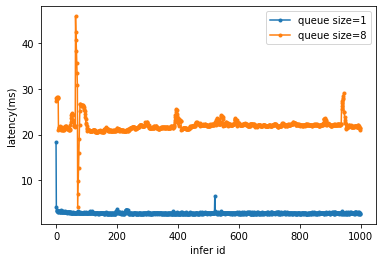

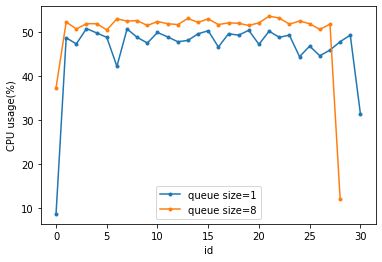

In [3]:
def test_infer_queue(num_request, num_infer):
    infer_queue = ov.AsyncInferQueue(compiled_model, num_request)
    cpu_usage = ovhelper.CPUUsage()
    inode = compiled_model.input(0)

    latency_list = []
    prof_list = []
    def callback(request, userdata):
        id = userdata
        latency_list.append(request.latency)
        prof_list.append(request.profiling_info)

    infer_queue.set_callback(callback)

    cpu_usage.start()
    t0 = time.time()
    for i in range(num_infer):
        input = ov.Tensor(inode.get_element_type(), inode.get_shape())
        input.data[:] = i
        infer_queue.start_async({0: input}, userdata=i)
    infer_queue.wait_all()
    cpu = cpu_usage.end()
    wtime = time.time() - t0
    fps = num_infer/wtime
    return latency_list, prof_list, fps, wtime, cpu

import matplotlib.pyplot as plt

NRlist=[1, 8]
TestResult={}
for num_request in NRlist:
    TestResult[num_request] = test_infer_queue(num_request, 1000)
    latency_list, prof_list, fps, wtime, cpu = TestResult[num_request]
    print("num_request={}: time_used={:.1f} sec, fps={:.1f}, cpu_usage={:.1f}%".format(
                        num_request,
                        wtime,
                        fps, 
                        sum(cpu)/len(cpu)))

def visualize_TestResult(TestResult):
    fig, ax = plt.subplots()
    for num_request, (latency_list, prof_list, fps, wtime, cpu) in TestResult.items():
        ax.plot(latency_list, '.-', label="queue size={}".format(num_request))
    plt.ylabel("latency(ms)")
    plt.xlabel("infer id")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    for num_request, (latency_list, prof_list, fps, wtime, cpu) in TestResult.items():
        ax.plot(cpu, '.-', label="queue size={}".format(num_request))
    plt.ylabel("CPU usage(%)")
    plt.xlabel("id")
    plt.legend()
    plt.show()

visualize_TestResult(TestResult)

The test result is quite supprising:
 - `num_request=8` case has slightly higher performance than `num_request=1` case;
 - `num_request=8` case has slightly higher total cpu usage than `num_request=1` case;
 - `num_request=8` case has about 7~8 times more latency than `num_request=1` case;

the total CPU usage is around ~50%, this is reasonable since the server with 2 NUMA nodes and `NUM_STREAMS` property of CPU device is set to 1 by default and execution stream do not cross over NUMA nodes.

In [4]:
print("RANGE_FOR_STREAMS: {}".format(core.get_property(device, "RANGE_FOR_STREAMS")))
print("NUM_STREAMS: {}".format(core.get_property(device, "NUM_STREAMS")))

RANGE_FOR_STREAMS: (1, 88)
NUM_STREAMS: 1


Further check the profiling result we still see no differences:

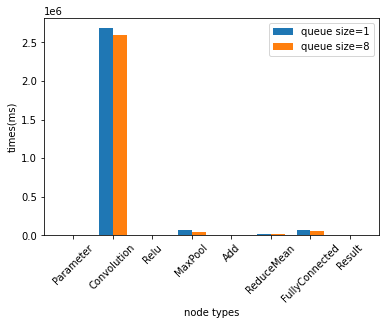

In [5]:
def visualize_profiling(TestResult):
    fig, ax = plt.subplots()
    width = 0.35  # the width of the bars
    dw = width
    for num_request, (latency_list, prof_list, _,_,_) in TestResult.items():
        node_type_times = {}
        for prof in prof_list:
            for p in prof:
                if (p.node_type not in node_type_times):
                    node_type_times[p.node_type] = 0
                node_type_times[p.node_type] += p.real_time.total_seconds()*1e6
        types = []
        times = []
        for k,v in node_type_times.items():
            types.append(k)
            times.append(v)
        x = np.arange(len(types))  # the label locations
        ax.bar(x-dw/2, times, width, label="queue size={}".format(num_request))
        dw = -dw

    ax.set_ylabel("times(ms)")
    ax.set_xlabel("node types")
    ax.set_xticks(x)
    ax.set_xticklabels(types, rotation=45)
    plt.legend()
    plt.show()

visualize_profiling(TestResult)

The fact is, although infer requests are submitted into the execution streams asynchronously, but there is only one execution stream (`NUM_STREAMS` is 1) which is capable of doing only one inference at a time, so latency of 8 infer requests are about 8x of the latency of 1 infer request case beacause each infer request has to wait for other 7 requests to finish before being actually executed by the execution stream.

So when NUM_STREAMS is 1 (which is refered to as `Conventional approach` in [openvino_docs_optimization_guide_dldt_optimization_guide.html](https://docs.openvino.ai/2021.3/openvino_docs_optimization_guide_dldt_optimization_guide.html)), multiple infer requests doesn't bring any performance advantage in terms of inferencing task.

But `num_request=8` case still introduced a little improvement in fps, that's because extra infer request allows the pre-processing part of code in python to be run in parallel with the inferencing of previous infer request, and if there is only 1 infer request, the preprocessing and inferencing can only be run in series.

Now let's try `Throughput-oriented approach` by setting `NUM_STREAMS` to 8 and do the same test again, be aware that you have to re-compile the model for any property changes to take effect:

num_request=1: time_used=22.4 sec, fps=44.7, cpu_usage=8.2%
num_request=8: time_used=2.1 sec, fps=484.8, cpu_usage=42.3%


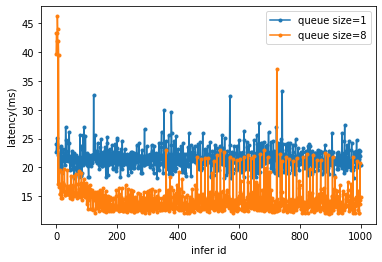

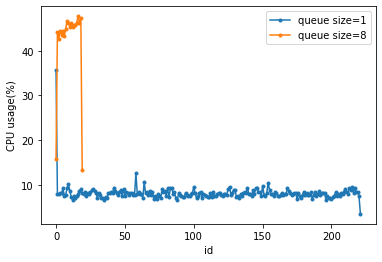

In [6]:
core.set_property(device, {"NUM_STREAMS":8})
compiled_model = core.compile_model(model, device)

NRlist=[1, 8]
TestResult={}
for num_request in NRlist:
    t0 = time.time()
    TestResult[num_request] = test_infer_queue(num_request, 1000)
    latency_list, prof_list, fps, wtime, cpu = TestResult[num_request]
    print("num_request={}: time_used={:.1f} sec, fps={:.1f}, cpu_usage={:.1f}%".format(
                        num_request,
                        wtime,
                        fps, 
                        sum(cpu)/len(cpu)))
visualize_TestResult(TestResult)

And we saw very different result in this case:
 - the `num_request=8, NUM_STREAMS=8` case achieves siginificant higher FPS comparing to `num_request=8, NUM_STREAMS=1` case with even lower cpu usage. As exaplained in `openvino_docs_optimization_guide_dldt_optimization_guide.html`, this is due to:
  > Less threads per stream => less sync, better locality, finer granularity
  
  > "Parallelize the outermost loop" rule of thumb

 - the `num_request=1` case took 7x~8x more times to finish, because now 1 infer request can only be executed on 1/8 resources (all resources are evenly distributed/allocated exclusively to each execution stream).
 - the `num_request=1` case took only about the cpu usage about 1/5 of the `num_request=8` case, in theory it should be 1/8.


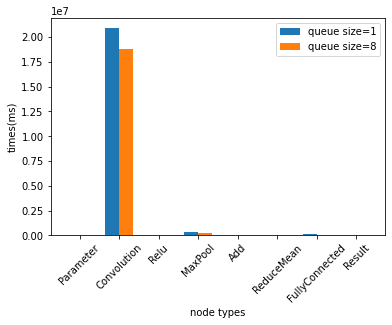

In [7]:
visualize_profiling(TestResult)